In [1]:
#Import all necessary modules. 
import numpy as np
import pickle
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
import pandas as pd
from sklearn.metrics import precision_recall_curve, auc, roc_curve, confusion_matrix, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold

In [2]:
#Load in training data feature matrix. 

matrix = pd.read_csv('/home/gregory178/Desktop/NAX project/NAX_SDH/train_data_.csv')
matrix = matrix.sample(random_state = 2023, frac = 1, ignore_index=True)  

# Drop the 'annot' column to create X_data
X_data = matrix.drop('annot', axis=1).reset_index(drop = True)

# Extract the 'BDSPPatientID' and 'annot' columns to create y_data_pre
y_data_pre = matrix[['BDSPPatientID', 'annot']].reset_index(drop = True)
assert len(X_data) == len(y_data_pre), "DataFrames must have the same length"
X_data['annot']=y_data_pre['annot']
print(X_data)
y_data = X_data[['BDSPPatientID', 'annot']]
print(y_data)
y_data_pre=y_data
print(y_data_pre)
y = y_data_pre['annot']
print(y)
X_data=X_data.drop(['annot'], axis=1)
X=X_data.drop(['BDSPPatientID', 'ContactDate', 'hospital', 'Unnamed: 0', 'NoteFileName', 'Site'], axis=1) 
print(X)

      Unnamed: 0  BDSPPatientID ContactDate  \
0           1328      118166468  2019-02-10   
1           2377      151027760  2018-07-07   
2           2821      151147664  2018-08-25   
3            982      118696581  2022-05-10   
4           1150      114871134  2018-02-14   
...          ...            ...         ...   
1495         732      115864242  2021-04-05   
1496        2556      150772328  2012-07-18   
1497         640      119972331  2019-08-19   
1498        2001      151202679  2015-11-25   
1499        2218      151038873  2015-08-31   

                                   NoteFileName   Site  CT  MRI  acut sdh_pos  \
0     Notes_13376418603_2401628103_20190210.txt    MGB   1    1             0   
1      Notes_1130886747_2345800771_20180707.txt  BIDMC   0    0             0   
2     Notes_1131006147_26220317926_20180825.txt  BIDMC   0    0             0   
3     Notes_13620842071_8922329630_20220510.txt    MGB   1    1             0   
4     Notes_13361437832_163574

In [3]:
# Initialize variables for storing results
all_predictions = []
all_true_labels = []
all_row_numbers = []
auc_cv = []
auc_pr = []
f1_cv = []
cf_cv = []
predictions = []
roc_curves = []
pr_curves = []
feature_importances_dict = {feature: [] for feature in X.columns}

# Dictionary to store patient IDs for each fold
fold_patient_ids = {f'fold_{i+1}': {'train': [], 'test': []} for i in range(10)}

# Initialize GroupKFold
gkf = GroupKFold(n_splits=10)

for cvi, (train_index, test_index) in enumerate(gkf.split(X, y, groups=y_data_pre['BDSPPatientID'])):
    Xtr, Xte = X.loc[train_index], X.loc[test_index]
    ytr, yte = y.loc[train_index], y.loc[test_index]
        
    fold_patient_ids[f'fold_{cvi+1}']['train'].extend(y_data_pre.loc[train_index, 'BDSPPatientID'].tolist())
    fold_patient_ids[f'fold_{cvi+1}']['test'].extend(y_data_pre.loc[test_index, 'BDSPPatientID'].tolist())


    model = RandomForestClassifier(
        n_estimators=100,
        random_state=2023,
        n_jobs=-1
    )
    
    search_spaces = {
        'n_estimators': (50, 500),
        'max_depth': (5, 50),
        'min_samples_split': (2, 20),
        'min_samples_leaf': (1, 20),
    }
    
    model_cv = BayesSearchCV(
        model,
        search_spaces,
        n_iter=50,
        scoring='roc_auc',
        n_jobs=47,
        cv=10,
        random_state=2023
    )
    
    model_cv.fit(Xtr, ytr)

    model = model_cv.best_estimator_

    ytr_pred = model.predict_proba(Xtr)[:, 1]
    yte_pred = model.predict_proba(Xte)[:, 1]

    fpr, tpr, cutoffs = roc_curve(ytr, ytr_pred)
    best_cutoff = cutoffs[np.argmax(tpr - fpr)]
    yte_pred_bin = (yte_pred > best_cutoff).astype(int)

    auc_cv.append(roc_auc_score(yte, yte_pred))
    f1_cv.append(f1_score(yte, yte_pred_bin))
    cf_cv.append(confusion_matrix(yte, yte_pred_bin))
    predictions.append(yte_pred_bin)

    model_filename = f'RF_model_train_allhospitals_Notes+ICD+Med_fold{cvi+1}.pickle'
    with open(model_filename, 'wb') as f:
        pickle.dump({'model':model, 'cutoff':best_cutoff}, f)


    fpr, tpr, cutoffs = roc_curve(yte, yte_pred)
    all_predictions.extend(yte_pred_bin)
    all_true_labels.extend(yte)
    all_row_numbers.extend(y_data.iloc[test_index]['BDSPPatientID'])

    roc_curves.append((fpr, tpr, roc_auc_score(yte, yte_pred)))
    precision, recall, thresholds = precision_recall_curve(yte, yte_pred)
    pr_curves.append((recall, precision, auc(recall, precision)))
    auc_pr_loop = auc(recall, precision)
    auc_pr.append(auc_pr_loop)

    feature_importances = model.feature_importances_
    for feature, importance in zip(X.columns, feature_importances):
        feature_importances_dict[feature].append(importance)

    print("Feature importances for this fold:")
    print(pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False))

    print(auc_cv)
    print(auc_pr)

fold_patient_ids_list = []
for fold, ids in fold_patient_ids.items():
    for train_id in ids['train']:
        fold_patient_ids_list.append({'fold': fold, 'type': 'train', 'patient_id': train_id})
    for test_id in ids['test']:
        fold_patient_ids_list.append({'fold': fold, 'type': 'test', 'patient_id': test_id})
fold_patient_ids_df = pd.DataFrame(fold_patient_ids_list)
fold_patient_ids_df.to_csv('RF_both_hospitals_fold_patient_ids_.csv', index=False)

Feature importances for this fold:
             Feature  Importance
24           sdh_pos    0.297135
68         ICD_S06.5    0.121383
21  neurosurgeri_pos    0.066075
25        subdur_pos    0.062123
69         ICD_432.1    0.057736
..               ...         ...
59     tentorium_neg    0.000000
58           tbi_neg    0.000000
39   craniectomi_neg    0.000000
37     burr hole_neg    0.000000
34      acut sdh_neg    0.000000

[71 rows x 2 columns]
[0.9640507518796992]
[0.8821970846362008]
Feature importances for this fold:
             Feature  Importance
24           sdh_pos    0.224173
68         ICD_S06.5    0.097876
21  neurosurgeri_pos    0.071271
25        subdur_pos    0.058625
69         ICD_432.1    0.056874
..               ...         ...
58           tbi_neg    0.000000
39   craniectomi_neg    0.000000
52           mvc_neg    0.000000
51           mva_neg    0.000000
59     tentorium_neg    0.000000

[71 rows x 2 columns]
[0.9640507518796992, 0.9869639376218324]
[0.882197

In [4]:
#Print AUROC and AUPRC
print(np.mean(auc_cv)) 
print(np.mean(auc_pr))

0.9758379441786016
0.8983226646205755


/tmp/ipykernel_8149/3187075371.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'CT' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  feature_importance_df.loc[i, 'Feature'] = feature


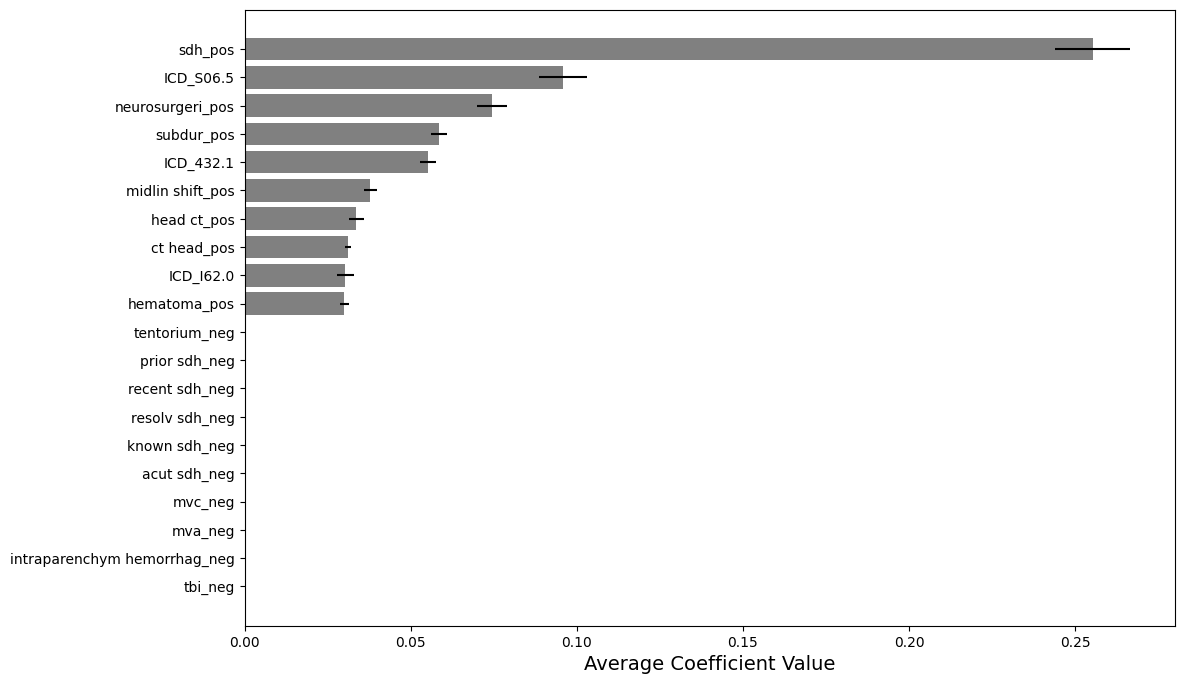

<Figure size 640x480 with 0 Axes>

In [5]:
# Aggregate feature importances by averaging over folds
feature_importance_df = pd.DataFrame(data={'Feature':[], 'Importance':[], 'Importance_se':[]})

for i, (feature, importances) in enumerate(feature_importances_dict.items()):
    feature_importance_df.loc[i, 'Feature'] = feature
    feature_importance_df.loc[i, 'Importance'] = np.mean(importances)
    feature_importance_df.loc[i, 'Importance_se'] = np.std(importances) / np.sqrt(len(importances))

feature_importance_df = feature_importance_df.sort_values('Importance', axis=0, ignore_index=True, ascending=False)

feature_importance_df.to_csv('/home/gregory178/Desktop/NAX project/NAX_SDH/RF_feat_importances_both_hospitals_.csv', index=False)

# Select top 10 and bottom 10 features
top_features = feature_importance_df.Feature.iloc[:10]
top_importances = feature_importance_df.Importance.iloc[:10]
top_importances_se = feature_importance_df.Importance_se.iloc[:10]
bottom_features = feature_importance_df.Feature.iloc[-10:]
bottom_importances = feature_importance_df.Importance.iloc[-10:]
bottom_importances_se = feature_importance_df.Importance_se.iloc[-10:]

# Combine top and bottom features for plotting
plot_features = pd.concat([top_features, bottom_features])
plot_importances = pd.concat([top_importances, bottom_importances])
plot_importances_se = pd.concat([top_importances_se, bottom_importances_se])

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(plot_features, plot_importances, color='grey', xerr=2*plot_importances_se, ecolor='black') 
plt.xlabel('Average Coefficient Value', fontsize=14)
# Invert y-axis to have the most important feature on top
plt.gca().invert_yaxis()  
plt.show()

# Save the plot
plt.savefig('/home/gregory178/Desktop/NAX project/NAX_SDH/RF_feat_importances_both_hospitals_.png')


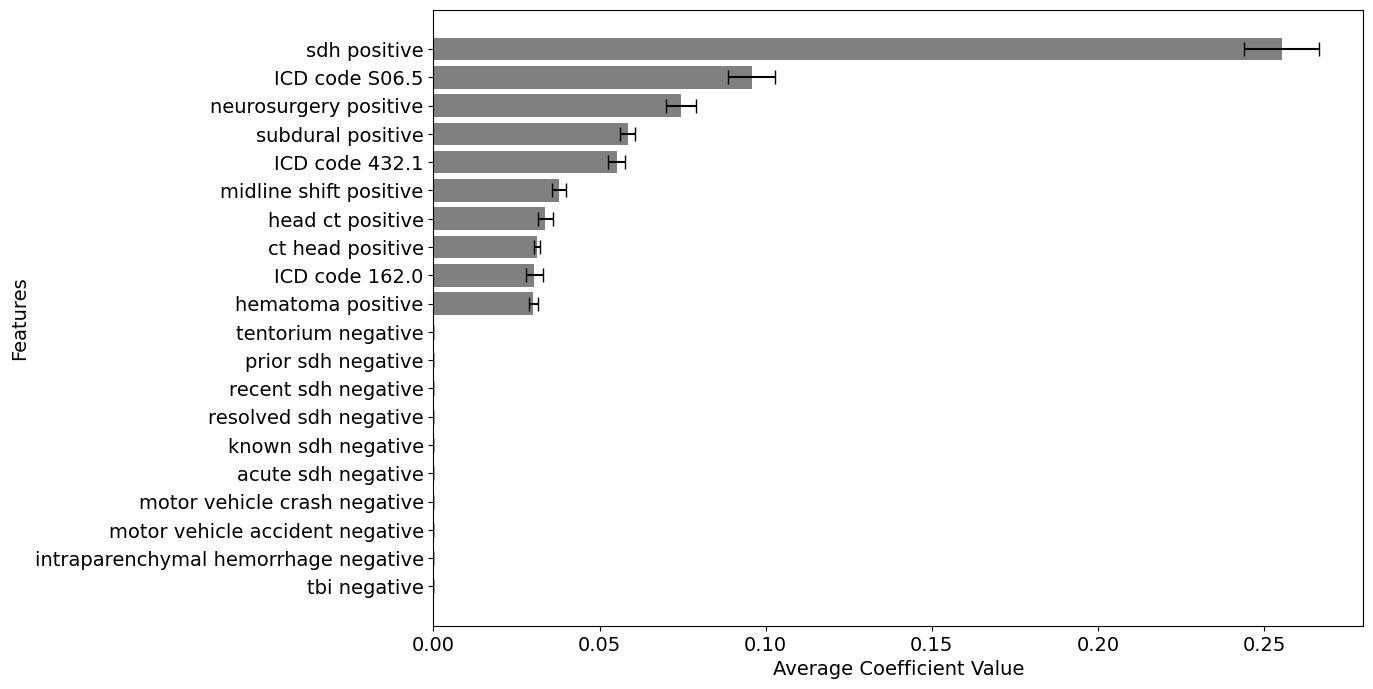

In [34]:

# Define custom feature names
custom_plot_features = [
    "sdh positive", "ICD code S06.5", "neurosurgery positive", "subdural positive", "ICD code 432.1", "midline shift positive", 
    "head ct positive", "ct head positive", "ICD code 162.0", "hematoma positive",
    "tentorium negative", "prior sdh negative", "recent sdh negative", "resolved sdh negative", "known sdh negative",
    "acute sdh negative", "motor vehicle crash negative", "motor vehicle accident negative", "intraparenchymal hemorrhage negative",
    "tbi negative"
]

# Ensure the length of custom features matches the length of plot_features
assert len(custom_plot_features) == len(plot_features), "The number of custom features must match the number of plot features."

# Plot feature importances
plt.figure(figsize=(12, 8))

# Create horizontal bar plot with error bars
bars = plt.barh(range(len(plot_features)), plot_importances, color='grey', xerr=2*plot_importances_se, ecolor='black', capsize=5)

# Set x-axis and y-axis labels with fontsize
plt.xlabel('Average Coefficient Value', fontsize=14)
plt.ylabel('Features', fontsize=14)

# Invert y-axis to have the most important feature on top
plt.gca().invert_yaxis()  

# Set custom y-axis labels with fontsize
plt.yticks(range(len(plot_features)), custom_plot_features, fontsize=14)

# Set the tick parameters for both x and y axes to have font size 14
plt.tick_params(axis='both', which='major', labelsize=14)

# Display the plot
plt.show()

In [7]:
#Print all confusion matrixes. 
cf_cv

[array([[100,  12],
        [  1,  37]]),
 array([[109,   5],
        [  4,  32]]),
 array([[110,   2],
        [ 12,  26]]),
 array([[103,   5],
        [  3,  39]]),
 array([[106,   4],
        [  8,  32]]),
 array([[116,   3],
        [  5,  26]]),
 array([[104,   5],
        [  9,  32]]),
 array([[105,   5],
        [  6,  34]]),
 array([[111,   5],
        [  8,  26]]),
 array([[113,   8],
        [  5,  24]])]

In [8]:
# Sum all confusion matrices to get overall counts
overall_cf_matrix = np.sum(cf_cv, axis=0)
print("Overall Confusion Matrix:\n", overall_cf_matrix)

Overall Confusion Matrix:
 [[1077   54]
 [  61  308]]


In [9]:
# Calculate metrics for each fold
def calculate_metrics(cf_matrix):
    TN, FP, FN, TP = cf_matrix.ravel()
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return accuracy, precision, recall, f1

for fold_index, cf_matrix in enumerate(cf_cv):
    accuracy, precision, recall, f1 = calculate_metrics(cf_matrix)
    print(f"Metrics for Fold {fold_index + 1}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}\n")

# Calculate overall metrics
overall_cf_matrix = np.sum(cf_cv, axis=0)
overall_accuracy, overall_precision, overall_recall, overall_f1 = calculate_metrics(overall_cf_matrix)
print("Overall Metrics:")
print(f"Accuracy: {overall_accuracy:.4f}")
print(f"Precision: {overall_precision:.4f}")
print(f"Recall: {overall_recall:.4f}")
print(f"F1 Score: {overall_f1:.4f}")


Metrics for Fold 1:
Accuracy: 0.9133
Precision: 0.7551
Recall: 0.9737
F1 Score: 0.8506

Metrics for Fold 2:
Accuracy: 0.9400
Precision: 0.8649
Recall: 0.8889
F1 Score: 0.8767

Metrics for Fold 3:
Accuracy: 0.9067
Precision: 0.9286
Recall: 0.6842
F1 Score: 0.7879

Metrics for Fold 4:
Accuracy: 0.9467
Precision: 0.8864
Recall: 0.9286
F1 Score: 0.9070

Metrics for Fold 5:
Accuracy: 0.9200
Precision: 0.8889
Recall: 0.8000
F1 Score: 0.8421

Metrics for Fold 6:
Accuracy: 0.9467
Precision: 0.8966
Recall: 0.8387
F1 Score: 0.8667

Metrics for Fold 7:
Accuracy: 0.9067
Precision: 0.8649
Recall: 0.7805
F1 Score: 0.8205

Metrics for Fold 8:
Accuracy: 0.9267
Precision: 0.8718
Recall: 0.8500
F1 Score: 0.8608

Metrics for Fold 9:
Accuracy: 0.9133
Precision: 0.8387
Recall: 0.7647
F1 Score: 0.8000

Metrics for Fold 10:
Accuracy: 0.9133
Precision: 0.7500
Recall: 0.8276
F1 Score: 0.7869

Overall Metrics:
Accuracy: 0.9233
Precision: 0.8508
Recall: 0.8347
F1 Score: 0.8427


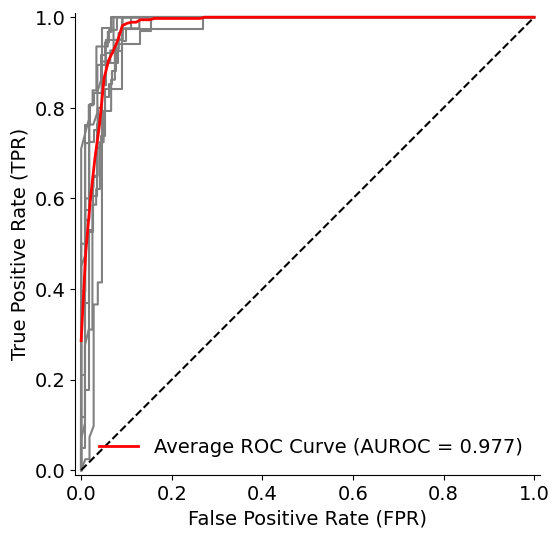

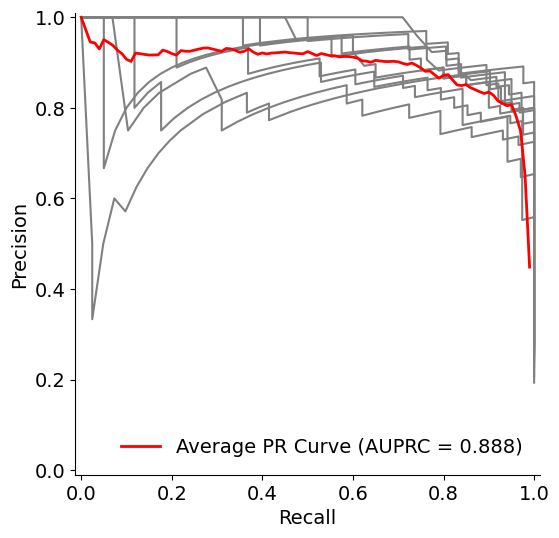

0.9758379441786016
0.8399072063385542


In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from sklearn.metrics import auc  

# Function to format the plot
def format_plot():
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xlabel('False Positive Rate (FPR)', fontsize=14)
    plt.ylabel('True Positive Rate (TPR)', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

# Plot all ROC curves overlaid on a single graph
plt.figure(figsize=(6, 6))
for fpr, tpr, auc_score in roc_curves:
    plt.plot(fpr, tpr, color='gray')  # Set line color to black

# Add a solid red line for the average ROC curve
mean_fpr = np.linspace(0, 1, 100)  # Extended range for x-axis
mean_tpr = np.mean([interp1d(fpr, tpr, bounds_error=False, fill_value=0)(mean_fpr) for fpr, tpr, _ in roc_curves], axis=0)

# Calculate AUROC for the average ROC curve
average_auc = auc(mean_fpr, mean_tpr)

# Plot the average ROC curve with its AUROC value in the legend
plt.plot(mean_fpr, mean_tpr, color='red', lw=2, label=f'Average ROC Curve (AUROC = {average_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random classifier
format_plot()
plt.axis('equal')
plt.xlim(-0.01, 1.01)  # Set x-axis limits
plt.ylim(-0.01, 1.01)  # Set y-axis limits
plt.legend(loc='lower right', fontsize=14, frameon=False)  
plt.savefig('RF_both_hospitals_AUC_iter_.png')
plt.show()

# Plot all PR curves overlaid on a single graph
plt.figure(figsize=(6, 6))
for recall, precision, auc_pr_loop in pr_curves:
    plt.plot(recall, precision, color='gray')  

# Add a solid red line for the average PR curve
mean_recall = np.linspace(0, 0.99, 100)  # Extended range for x-axis
mean_precision = np.mean([interp1d(recall, precision, bounds_error=False, fill_value=0)(mean_recall) for recall, precision, _ in pr_curves], axis=0)

# Calculate AUROC for the average ROC curve
average_prc = auc(mean_recall, mean_precision)

# Plot the average PR curve with its AUPRC value in the legend
plt.plot(mean_recall, mean_precision, color='red', lw=2, label=f'Average PR Curve (AUPRC = {average_prc:.3f})')

# Format the PR curve plot
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axis('equal')
plt.xlim(-0.01, 1.01)  # Set x-axis limits
plt.ylim(-0.01, 1.01)  # Set y-axis limits
plt.legend(loc='lower right', fontsize=14, frameon=False)  
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('RF_both_hospitals_PR_iter_.png')
plt.show()

# Create a DataFrame to hold the results
results_df = pd.DataFrame({'Unnamed: 0': all_row_numbers, 'annot': all_true_labels, 'prediction': all_predictions})

# Save the DataFrame to a CSV file
results_df.to_csv('RF_LR_iter_pred_rr_both_hospitals_.csv', index=False)

# Calculate the final AUC and F1
auc_final = np.mean(auc_cv)
f1_final = np.mean(f1_cv)

# Save all the data
df = pd.DataFrame()
df['auc'] = auc_cv
df['f1s'] = f1_cv
df['auc_pr'] = auc_pr
df_pred = pd.DataFrame()
df1 = pd.DataFrame(predictions[0])
df2 = pd.DataFrame(predictions[1])
df3 = pd.DataFrame(predictions[2])
df4 = pd.DataFrame(predictions[3])
df5 = pd.DataFrame(predictions[4])
df_pred = pd.concat([df1, df2, df3, df4, df5]).reset_index()
df.to_csv('RF_LR_iter_both_hospitals_.csv')

# Print final Data
print(auc_final)
print(f1_final)
